<a href="https://colab.research.google.com/github/HanifaElahi/Mediapipe/blob/main/Holistic_Mediapipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Mediapipe Holistics***

---


* Live perception of simultaneous human pose, face landmarks, and hand tracking in real-time on mobile devices can enable various modern life applications: fitness and sport analysis, gesture control and sign language recognition, augmented reality try-on and effects. 
* MediaPipe offers fast and accurate, yet separate, solutions for these tasks.
* Combining them all in real-time into a semantically consistent end-to-end solution is a uniquely difficult problem requiring simultaneous inference of multiple, dependent neural network.


### ***ML Pipeline***


---


* The MediaPipe Holistic pipeline integrates separate models for pose, face and hand components, each of which are optimized for their particular domain.
* However, because of their different specializations, the input to one component is not well-suited for the others.
* The pose estimation model, for example, takes a lower, fixed resolution video frame (256x256) as input. But if one were to crop the hand and face regions from that image to pass to their respective models, the image resolution would be too low for accurate articulation. Therefore, MediaPipe Holistic is designed as a multi-stage pipeline, which treats the different regions using a region appropriate image resolution.


Mediapipe first estimate the human pose with BlazePose’s pose detector and subsequent landmark model. Then, using the inferred pose landmarks, derive three regions of interest (ROI) crops for each hand (2x) and the face, and employ a re-crop model to improve the ROI. Then crop the full-resolution input frame to these ROIs and apply task-specific face and hand models to estimate their corresponding landmarks. Finally, merge all landmarks with those of the pose model to yield the full 540+ landmarks.

* To streamline the identification of ROIs for face and hands, utilize a tracking approach similar to the one we use for standalone face and hand pipelines. It assumes that the object doesn’t move significantly between frames and uses estimation from the previous frame as a guide to the object region on the current one. 
* However, during fast movements, the tracker can lose the target, which requires the detector to re-localize it in the image. 
* MediaPipe Holistic uses pose prediction (on every frame) as an additional ROI prior to reduce the response time of the pipeline when reacting to fast movements.
* This also enables the model to retain semantic consistency across the body and its parts by preventing a mixup between left and right hands or body parts of one person in the frame with another.

In addition, the resolution of the input frame to the pose model is low enough that the resulting ROIs for face and hands are still too inaccurate to guide the re-cropping of those regions, which require a precise input crop to remain lightweight. To close this accuracy gap , Mediapipe use lightweight face and hand re-crop models that play the role of spatial transformers and cost only ~10% of corresponding model’s inference time.


# Models

---



***Landmark Models***


MediaPipe Holistic utilizes the pose, face and hand landmark models in MediaPipe Pose, MediaPipe Face Mesh and MediaPipe Hands respectively to generate a total of 543 landmarks (33 pose landmarks, 468 face landmarks, and 21 hand landmarks per hand).


***Hand Recrop Model***



For cases when the accuracy of the pose model is low enough that the resulting ROIs for hands are still too inaccurate we run the additional lightweight hand re-crop model that play the role of spatial transformer and cost only ~10% of hand model inference time.


# ***Installation***

In [1]:
!pip install mediapipe

     |████████████████████████████████| 32.8 MB 1.5 MB/s 


# ***Uploading Images***

In [2]:
from google.colab import files

uploaded = files.upload()

Saving pose_1.jpg to pose_1.jpg
Saving pose_2.png to pose_2.png
Saving pose_3.jpg to pose_3.jpg
Saving pose_4.jpg to pose_4.jpg
Saving pose_5.jpg to pose_5.jpg
Saving pose_6.jpg to pose_6.jpg


# ***Importing Libraries***

In [3]:
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np

# ***Mediapipe Holistics***

In [4]:
#setting desired width and height of images
DESIRED_HEIGHT = 360
DESIRED_WIDTH = 360

In [5]:
#function to resize and image show

def resize_and_show(image):
  
  h, w = image.shape[:2]
  
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  
  cv2_imshow(img)


pose_1.jpg


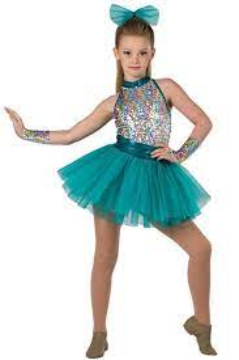

pose_2.png


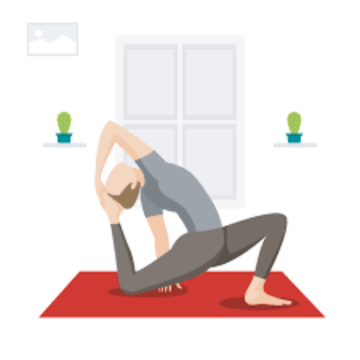

pose_3.jpg


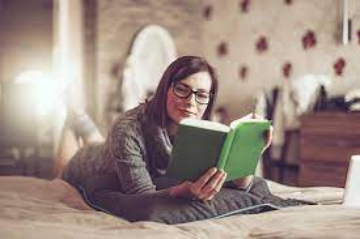

pose_4.jpg


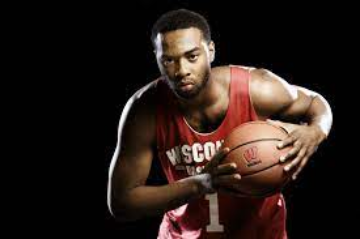

pose_5.jpg


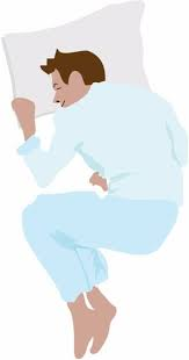

pose_6.jpg


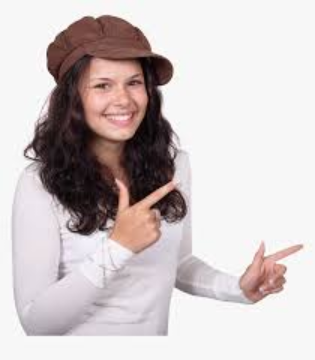

In [6]:
# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}
# Preview the images.
for name, image in images.items():
  print(name)   
  resize_and_show(image)

In [7]:
#initializing
import mediapipe as mp
mp_holistic = mp.solutions.holistic

In [8]:
# Import drawing_utils and drawing_styles.
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

Nose coordinates: (103.87022405862808, 46.349819749593735)
Pose landmarks of pose_1.jpg:


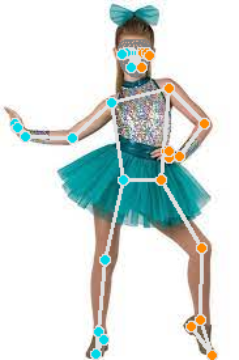

Nose coordinates: (76.95557400584221, 107.04960376024246)
Pose landmarks of pose_2.png:


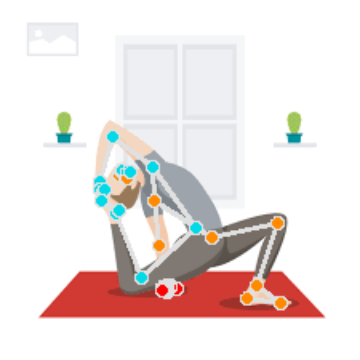

Nose coordinates: (143.3536857366562, 82.79513356089592)
Pose landmarks of pose_3.jpg:


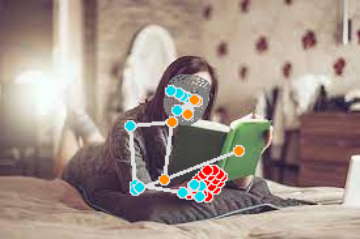

Nose coordinates: (138.16402703523636, 54.38470298051834)
Pose landmarks of pose_4.jpg:


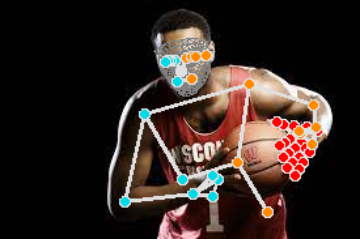

Nose coordinates: (50.43790662288666, 78.86231392621994)
Pose landmarks of pose_5.jpg:


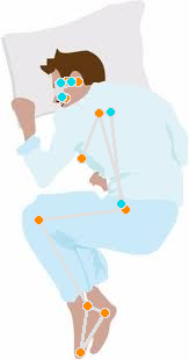

Nose coordinates: (84.7728681564331, 65.54505586624146)
Pose landmarks of pose_6.jpg:


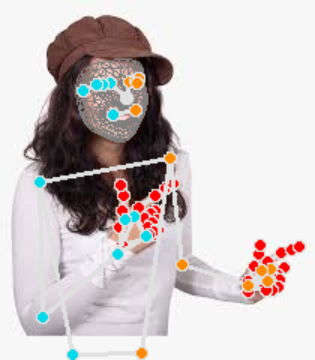

In [9]:
# Run MediaPipe Holistic and draw pose landmarks.
with mp_holistic.Holistic(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2,smooth_landmarks=True, enable_segmentation=True, smooth_segmentation=True,refine_face_landmarks=True) as holistic:
  for name, image in images.items():
    # Convert the BGR image to RGB and process it with MediaPipe Pose.
    results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print nose coordinates.
    image_hight, image_width, _ = image.shape
    if results.pose_landmarks:
      print(
        f'Nose coordinates: ('
        f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].x * image_width}, '
        f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].y * image_hight})'
      )

    # Draw pose landmarks.
    print(f'Pose landmarks of {name}:')
    
    annotated_image = image.copy()

    mp_drawing.draw_landmarks(annotated_image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(annotated_image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(annotated_image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION,landmark_drawing_spec=None,connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
    mp_drawing.draw_landmarks(annotated_image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    resize_and_show(annotated_image)

Nose world landmark:
x: -0.009242437779903412
y: -0.5900763273239136
z: -0.3064177930355072
visibility: 0.9999816417694092

Pose world landmarks of pose_1.jpg:


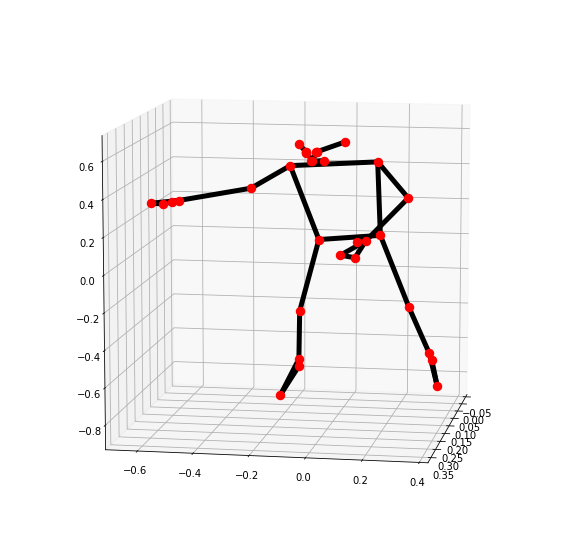

Nose world landmark:
x: -0.4344113767147064
y: -0.39650505781173706
z: -0.010367457754909992
visibility: 0.9846009612083435

Pose world landmarks of pose_2.png:


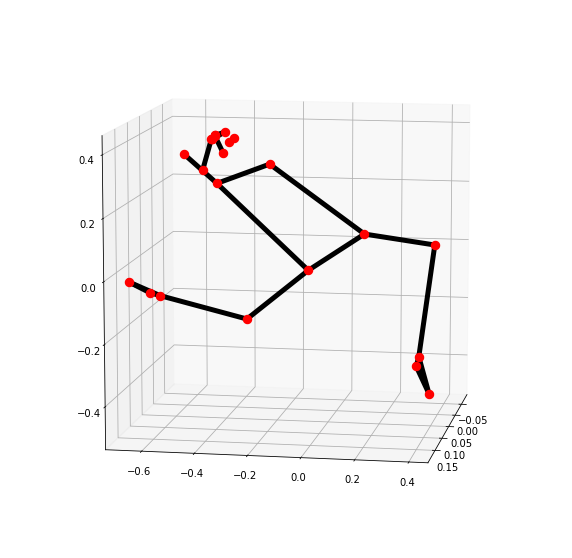

Nose world landmark:
x: 0.2217494249343872
y: -0.40133318305015564
z: -0.30317965149879456
visibility: 0.9988588094711304

Pose world landmarks of pose_3.jpg:


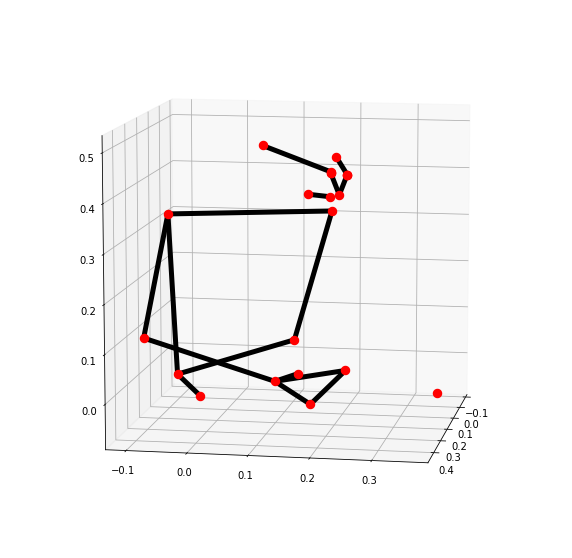

Nose world landmark:
x: -0.10124987363815308
y: -0.3270026743412018
z: -0.5928161144256592
visibility: 0.9987307190895081

Pose world landmarks of pose_4.jpg:


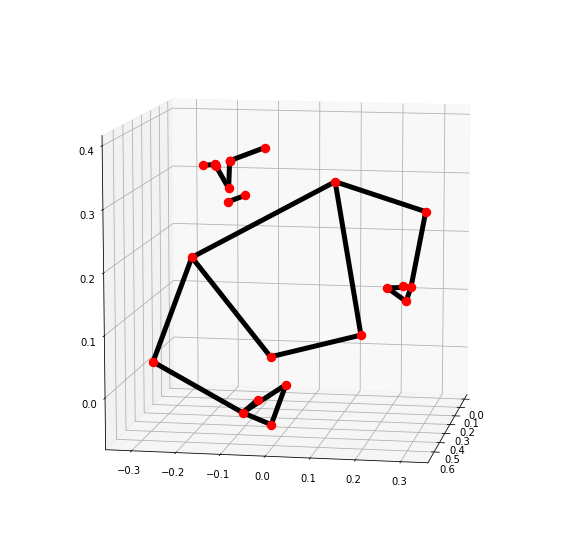

Nose world landmark:
x: -0.24923378229141235
y: -0.4142151474952698
z: -0.03233420476317406
visibility: 0.9984104633331299

Pose world landmarks of pose_5.jpg:


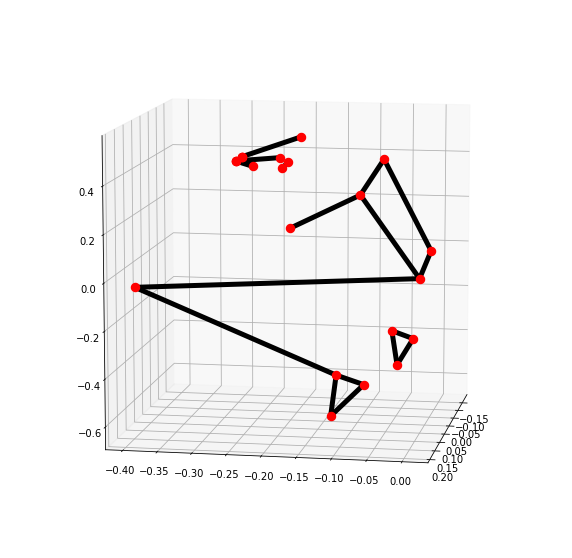

Nose world landmark:
x: 0.04028042405843735
y: -0.5143406987190247
z: -0.4358617663383484
visibility: 0.9999897480010986

Pose world landmarks of pose_6.jpg:


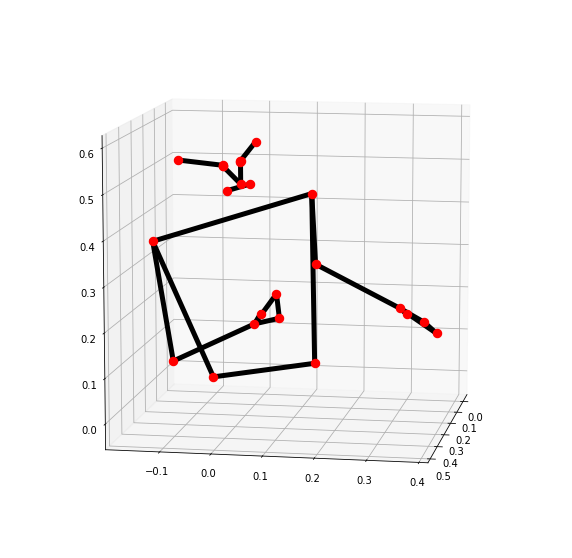

In [10]:
# Run MediaPipe Holistic and plot 3d pose world landmarks.
with  mp_holistic.Holistic(static_image_mode=True) as holistic:
  for name, image in images.items():
    results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print the real-world 3D coordinates of nose in meters with the origin at
    # the center between hips.
    print('Nose world landmark:'),
    print(results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.NOSE])
    
    # Plot pose world landmarks.
    print(f'Pose world landmarks of {name}:')
    mp_drawing.plot_landmarks(
        results.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS)

# **Source**:


---


1. https://colab.research.google.com/drive/16UOYQ9hPM6L5tkq7oQBl1ULJ8xuK5Lae?usp=sharing#scrollTo=vp-ohtBNSFkj
2. https://google.github.io/mediapipe/solutions/holistic.html